In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
# Enable inline plotting  
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
cores_per_node = {
                  '1': [1, 4, 8, 16, 28],
                  '2': [28, 42, 56],
                  '4': [84, 98, 112],
                  '6': [140, 154, 168],
                  '8': [196, 210, 224],
                  '12': [308, 322, 336],
                  '16': [420, 434, 448]
                  }

repeats = 3

In [3]:
def reduce_to_means(N, n):
    """Helper function to reduce data from numpy arrays.
    
    First it takes the mean across all ranks for each timing,
    then it takes the mean and standard deviation across the repeats.
    
    Parameters
    ----------
    n : int
        number of processes used in run
        
    Returns
    -------
    means : list
        mean across number of repeats for each timing
    stds : list
        standard deviation across repeats for each timing
        
    """
    
    init_total = np.empty(3)
    open_h5py = np.empty_like(init_total)
    io = np.empty_like(init_total)
    io_per_frame = np.empty_like(init_total)
    rmsd = np.empty_like(init_total)
    rmsd_per_frame = np.empty_like(init_total)
    comm_gather = np.empty_like(init_total)
    total = np.empty_like(init_total)

    _dict = {f'a{i}': np.load(f'{N}node_{i}/{n}process_times.npy') for i in range(1, repeats+1)}

    for i, array in enumerate(_dict.values()):
        init_total[i] = np.mean(array[:, 1])
        open_h5py[i] = np.mean(array[:, 2])
        io[i] = np.mean(array[:, 3])
        io_per_frame[i] = np.mean(array[:, 4])
        rmsd[i] = np.mean(array[:, 5])
        rmsd_per_frame[i] = np.mean(array[:, 6])
        comm_gather[i] = np.mean(array[:, 7])
        total[i] = np.mean(array[:, 8])

    means = [n, np.mean(init_total), np.mean(open_h5py), np.mean(io), np.mean(io_per_frame),
             np.mean(rmsd), np.mean(rmsd_per_frame), np.mean(comm_gather), np.mean(total)]
    stds = [n, np.std(init_total), np.std(open_h5py), np.std(io), np.std(io_per_frame),
             np.std(rmsd), np.std(rmsd_per_frame), np.std(comm_gather), np.std(total)]

    return means, stds

In [5]:
def get_raw_data(N, n, averaged=False):
    """Gets the raw data from all repeats and displays in a pandas DataFrame.
    
    If averaged=True, it takes the average and standard deviation across all 
    repeats for all (rank x timing) elements.
    
    Parameters
    ----------
    n : int
        number of processes used in run
    averaged: bool (optional)
    
    Returns
    -------
    all data (if averaged=False) : pd.DataFrame
        pandas dataframe of raw data arrays stacked horizontally with no reductions
    means (if averaged=True) : pd.DataFrame
        mean across repeats for each (rank x timing) element
    stds (if averaged=True) : pd.DataFrame 
        standard deviation across repeats for each (rank x timing) element
    
    """
    
    
    columns = ['rank', 'init_total', 'open_h5py',  'io', 'io/frame', 
               'rmsd_compute', 'rmsd_compute/frame', 'comm_gather',
               'total bench']
    
    _dict = {f'a{i}': np.load(f'{N}node_{i}/{n}process_times.npy') for i in range(1, repeats+1)}
    
    if averaged:
        means_buffer = np.zeros(shape=(n,19), dtype=float)
        stds_buffer = np.zeros(shape=(n,19), dtype=float)
        
        # fills in means and std arrays 1 element at a time
        for i in range(n):
            for j in range(19):
                temp_array = np.empty(repeats, dtype=float) 
                for trial, k in enumerate(range(len(temp_array)), 1):
                    temp_array[k] = _dict[f'a{trial}'][i, j]
                means_buffer[i, j] = np.mean(temp_array)
                stds_buffer[i, j] = np.std(temp_array)
                
        return pd.DataFrame(list(means_buffer), columns=columns).set_index('rank'), pd.DataFrame(list(stds_buffer), columns=columns).set_index('rank')
    
    else:
        arrays = tuple(_dict.values())
        a = np.hstack(arrays)
        
        return pd.DataFrame(list(a), columns=repeats*columns)

In [8]:
def all_process_dataframe():
    """Gives DataFrame of averaged timings for all N_process runs.
    
    Returns
    -------
    times_dframe : pd.DataFrame
        benchmark times with timings first averaged across all ranks, then averaged across repeats
    stds_dframe : pd.DataFrame 
        standard deviation of the timings when averaged across repeats   
    
    """
    columns = ['N_Processes', 'Total_Initialize', 'Initialize_h5py', 
               'IO', 'IO/Frame', 'RMSD', 'RMSD/Frame', 'Comm_Gather', 
               'Total_Benchmark_Time']
    
    data_buffer = np.empty(shape=(14,9), dtype=float)
    stds_buffer = np.empty(shape=(14,9), dtype=float)
    
    count = -1
    for N in [1,2,4,6]:
        for i, cores in enumerate(cores_per_node[f'{N}'], count+1):
            count = i
            means, stds = reduce_to_means(N, cores)
            for j in range(9):
                data_buffer[i, j] = means[j]
                stds_buffer[i, j] = stds[j]

    times_dframe = pd.DataFrame(list(data_buffer), columns=columns).set_index('N_Processes')
    stds_dframe = pd.DataFrame(list(stds_buffer), columns=columns).set_index('N_Processes')
            
    return times_dframe, stds_dframe

In [14]:
def plot_line_graph(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_io_stds = stds_dataframe.IO.to_numpy()
            t_rmsd_stds = stds_dataframe.RMSD.to_numpy()
            t_init_total_stds = stds_dataframe.Total_Initialize.to_numpy()
            t_init_h5py_stds = stds_dataframe.Initialize_h5py.to_numpy()
            t_comm_stds = stds_dataframe.Comm_Gather.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_io_stds, t_rmsd_stds, t_init_total_stds, t_comm_stds]
        timing_dataframe.loc[:, ['IO','RMSD','Total_Initialize','Comm_Gather']].plot(color=['blue',
                                                                            'orange', 
                                                                            'green',
                                                                            'red'], yerr=yerrs, ax=axes, marker='o')
        lgd = plt.legend(['IO', 'RMSD','Total Initialize', 'Communication'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 250)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [21]:
def plot_scaling(timing_dataframe, stds_dataframe=None, init_subtracted=False):
        
    n_proc = timing_dataframe.index.to_numpy()
    t_io = timing_dataframe.IO.to_numpy()
    t_init = timing_dataframe.Total_Initialize.to_numpy()
    t_rmsd = timing_dataframe.RMSD.to_numpy()
    t_total = timing_dataframe.Total_Benchmark_Time.to_numpy()
    
    if init_subtracted:
        t_total = t_total - t_init
        
    speedup_rmsd = [t_rmsd[0]/t_rmsd[i] for i in range(len(t_rmsd))]
    efficiency_rmsd = [speedup_rmsd[i]/n_proc[i] for i in range(len(t_rmsd))]
    speedup_io = [t_io[0]/t_io[i] for i in range(len(t_io))]
    efficiency_io = [speedup_io[i]/n_proc[i] for i in range(len(t_io))]
    speedup_total = [t_total[0]/t_total[i] for i in range(len(t_total))]
    efficiency_total = [speedup_total[i]/n_proc[i] for i in range(len(t_total))]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    plt.style.use('ggplot')
    sns.set_style('ticks')

    ax1.plot(n_proc, n_proc, 'k--', linewidth='3.5')
    ax1.plot(n_proc, speedup_rmsd, marker='.', color='orange', label='RMSD', linewidth='3')
    ax1.plot(n_proc, speedup_io, marker='.', color='blue', label='IO', linewidth='3')
    ax1.plot(n_proc, speedup_total, linestyle='--', marker='.', color='red', label='Total', linewidth='3')
    ax1.set(xlim=[1,224], ylim=[1,224], title='Speedup', ylabel='Speedup')
    ax1.set_title('Speedup', fontsize=24)
    ax1.set_xlabel('$N_{Processes}$', fontsize=24)
    ax1.set_ylabel('$S(N) = t_1/t_N$', fontsize=24)
    ax1.legend(fontsize=20)
    ax1.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    
    ax2.plot(n_proc, efficiency_rmsd, marker='.', color='orange', label='RMSD',  linewidth='3')
    ax2.plot(n_proc, efficiency_io, marker='.', color='blue', label='IO', linewidth='3')
    ax2.plot(n_proc, efficiency_total, marker='.', color='red', label='Total', linewidth='3')
    ax2.set(xlim=[1,224], ylim=[0,1.2])
    ax2.set_title('Efficiency', fontsize=24)
    ax2.set_xlabel('$N_{Processes}$', fontsize=24)
    ax2.set_ylabel('E(N) = S(N)/N', fontsize=24)
    ax2.legend(fontsize=20)
    ax2.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')

In [16]:
times, stds = all_process_dataframe()
times

,Total_Initialize,Initialize_h5py,IO,IO/Frame,RMSD,RMSD/Frame,Comm_Gather,Total_Benchmark_Time
N_Processes,,,,,,,,
1.0,0.078183,0.045030,3262.036155,0.036205,14.783523,0.000164,0.000333,3276.898194
4.0,0.060292,0.025759,1204.463751,0.053472,4.501701,0.000200,0.000545,1209.026289
8.0,0.101445,0.067189,676.226425,0.060042,2.720356,0.000242,0.000551,679.048776
16.0,0.079252,0.042404,598.984455,0.106368,1.469535,0.000261,0.000394,600.533636
28.0,0.198820,0.147127,508.769612,0.158108,0.891346,0.000277,0.000386,509.860165
28.0,0.183276,0.134990,430.654632,0.133833,0.889605,0.000276,0.000419,431.727932
42.0,0.350720,0.292637,261.127226,0.121722,0.588330,0.000274,0.000386,262.066661
56.0,0.315349,0.262546,253.697418,0.157681,0.484297,0.000301,0.000561,254.497624
84.0,0.411453,0.283199,186.518701,0.173891,0.315186,0.000294,0.000619,187.245959


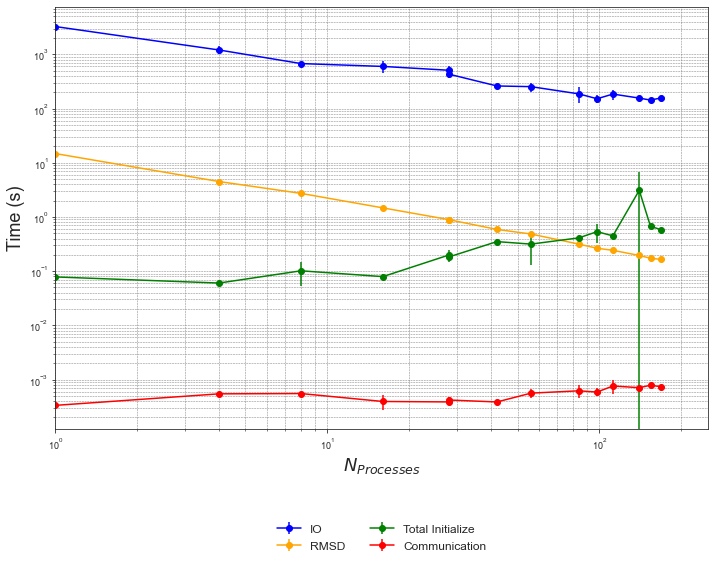

In [17]:
plot_line_graph(times, stds)

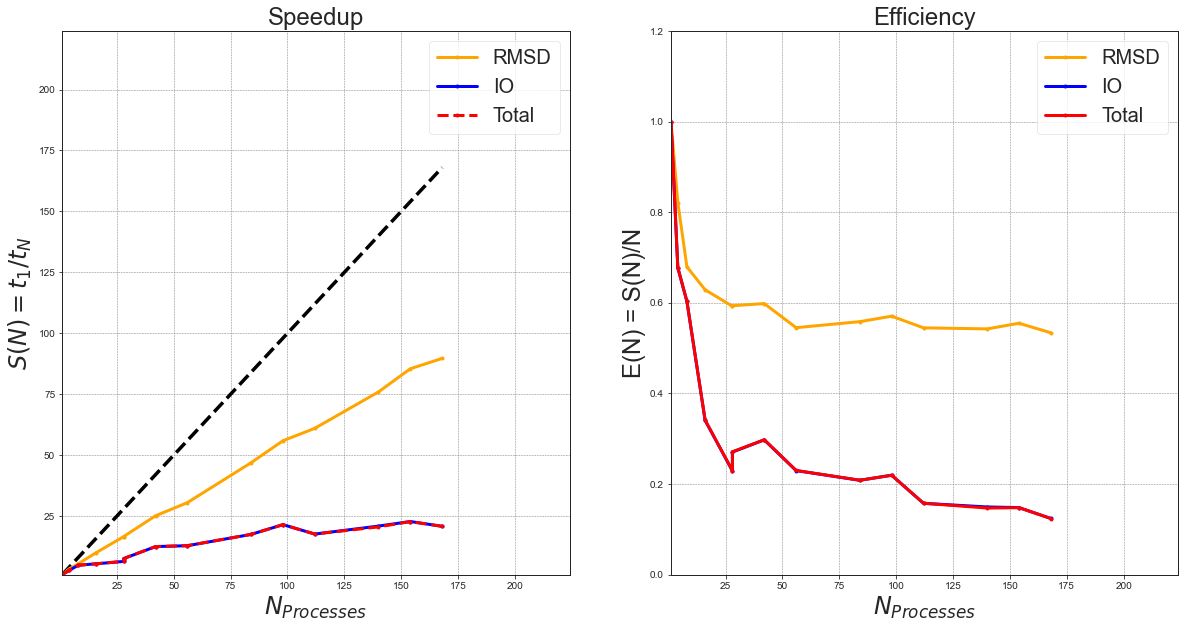

In [22]:
plot_scaling(times, stds)